# DNN BS per convolution output size

Run on Mouse
```
19Jun1656peter@mouse:~/DNNMark$ python run_series.py
Logdir logs/dnnmark_timings_and_profiles/
Have 320 tasks
checking GPU 0....Starting
./run_dnnmark.sh -n 10 -k 32 --debug
...

```

Log files
```
dnn_bwd_conv_conv256_bs20_18837.nvprof  - profiling data (kernels)
dnn_bwd_conv_conv256_bs20.log           - stdout + stderr (parse for run time)
dnn_bwd_conv_conv256_bs20.log.nvsmi     - nvidia-smi memory usage data
dnn_bwd_conv_conv256_bs20_%p.nvprof     - run for nvprof output (not used)
```



## Read .log files

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import lib
import seaborn as sns
import itertools
from cycler import cycler
from random import randint
import math

In [2]:
batch_conv_pattern = re.compile(r"b\s*(\d+)\s+conv\s*([0-9\.]+)")
output_pattern = re.compile(r"Total running time\(ms\): ([0-9\.\e\+]+)")
filename_pattern=re.compile(r"^dnn_bwd_conv_conv([0-9]+)_bs([0-9]+)\.log$")

pars = {
    "batch_conv_pattern": batch_conv_pattern,
    "output_pattern" : output_pattern,
    "filename_pattern" : filename_pattern,
}

In [3]:
logdir="logs/dnnmark_timings_and_profiles"
dflog = lib.lib.readLogs(logdir,pars,debug=False)
print dflog.shape
dflog.drop("epoch", axis=1, inplace=True)
dflog[["batch","conv"]] = dflog[["batch","conv"]].astype(np.int)
# Convert ms to s
dflog["time"] = dflog["time"]/1000
dflog.sort_values(by=["batch","conv"],inplace=True)
dflog.reset_index(drop=True,inplace=True)
dflog.head()

(47, 4)


,batch,conv,time
0,10,32,0.008198
1,10,64,0.013868
2,10,128,0.023895
3,10,256,0.047698
4,20,32,0.013742


In [4]:
dfconvs = dflog.pivot(columns="conv",index="batch",values="time")
dfconvs.head()

conv,32,64,128,256
batch,,,,
10,0.008198,0.013868,0.023895,0.047698
20,0.013742,0.027321,0.046843,0.087537
30,0.023925,0.041216,0.067447,0.124813
40,0.032060,0.049383,0.085220,NaN
50,0.034618,0.055458,0.120191,NaN


## Read .nvsmi files

In [5]:
conv_batch_pattern = re.compile(r"dnn_bwd_conv_conv(\d+)_bs(\d+)\.log\.nvsmi")
filename_pattern = conv_batch_pattern

def readNVSMIfiles(logdir,pars):
    conv_batch_pattern = pars["conv_batch_pattern"]
    filename_pattern = pars["filename_pattern"]
    list_command = "ls -1 "+logdir
    nvsmi_files=[]
    proc = subprocess.Popen(list_command.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            nvsmi_files.append(os.path.abspath(os.path.join(logdir,line)))
    print len(nvsmi_files)
    
    columns=["time","GPU","Memory Total (MiB)","Memory Used (MiB)","batch","conv"]
    df_nvsmi = pd.DataFrame(data=None,columns=columns)
    ind = 0 # DataFrame row numebr (index)
    for lf in nvsmi_files:
        logfile = lf.strip(" \n")
        df = pd.read_csv(logfile,names=columns)
        df["Memory Used (MiB)"] = df["Memory Used (MiB)"].astype(np.int)
        # Get MAX from Memory Used values, leave only one row
        df.sort_values(by="Memory Used (MiB)",inplace=True,ascending=False)
        df.reset_index(drop=True,inplace=True)
        df = df.iloc[:1]
        m = conv_batch_pattern.search(logfile)
        bs = 0
        conv = 0
        if m:
            bs = m.group(2)
            conv = m.group(1)
        df["batch"] = bs
        df["conv"] = conv
        if df.shape[0] > 0:
            df_nvsmi = pd.concat([df_nvsmi,df])
    df_nvsmi.reset_index(drop=True,inplace=True)
    df_nvsmi.drop(["time","GPU"],axis=1,inplace=True)
    df_nvsmi[["batch","conv","Memory Total (MiB)", "Memory Used (MiB)"]] = df_nvsmi[["batch","conv","Memory Total (MiB)", "Memory Used (MiB)"]].astype(np.int)
    df_nvsmi.sort_values(by=["batch","conv"],inplace=True,ascending=True)
    df_nvsmi.reset_index(drop=True,inplace=True)
    return df_nvsmi

pars = {"conv_batch_pattern":conv_batch_pattern,
        "filename_pattern":filename_pattern }
df_nvsmi = readNVSMIfiles(logdir,pars)
print df_nvsmi.shape
df_nvsmi.head()

160
(160, 4)


,Memory Total (MiB),Memory Used (MiB),batch,conv
0,5058,780,10,32
1,5058,938,10,64
2,5058,1254,10,128
3,5058,1884,10,256
4,5058,952,20,32


## Merge log and nvsmi dataframes

In [6]:
dfmerg = pd.merge(dflog,df_nvsmi,on=["batch","conv"],how='inner')
dfmerg.sort_values(by=["batch","conv"],ascending=True,inplace=True)
dfmem = dfmerg.pivot(index="batch",columns="conv",values="Memory Used (MiB)")
dfmem["Memory Total(MiB)"] = dfmerg.loc[0,"Memory Total (MiB)"]
dfmem.head()

conv,32,64,128,256,Memory Total(MiB)
batch,,,,,
10,780.0,938.0,1254.0,1884.0,5058
20,952.0,1270.0,1902.0,3160.0,5058
30,1128.0,1602.0,2546.0,4436.0,5058
40,1296.0,1930.0,3164.0,NaN,5058
50,1468.0,2258.0,3834.0,NaN,5058


## Plot times and memory

In [7]:
def getColorList(cmap,n):
    cmap = cm.get_cmap(cmap, n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i),keep_alpha=True)
        colors.append(c)
    return colors

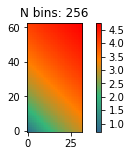

In [8]:
colors1 = getColorList("viridis",4)
colors2 = getColorList("autumn_r",3)
colors = colors1[1:-1] + colors2[1:]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)
lib.plotter.testColorMap(cmap)
plt.rc('axes', prop_cycle=(cycler('color', colors)))

In [9]:
from matplotlib.ticker import MultipleLocator

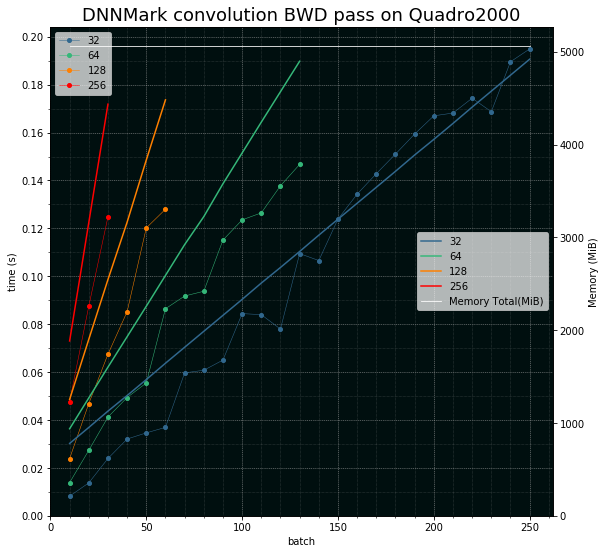

In [10]:
fig,ax = plt.subplots(figsize=(9,9))
dfconvs.plot(ax=ax,lw=0.5,marker="o",ms=4,alpha=1,fillstyle="full")
ax.set_title("DNNMark convolution BWD pass on Quadro2000",fontsize=18)
ax1 = ax.twinx()
dfmem.iloc[:,:-1].plot(lw=1.5,ax=ax1)
dfmem.iloc[:,-1].plot(lw=.8,ax=ax1,c="w")
ax1.set_ylim(0,None)
ax.set_ylim(0,None)

def gridAndLabel(ax,ax1):
    ax.grid(ls=":",alpha=.6)
    ax.set_ylabel("time (s)")
    ax.set_xlim(0,None)
    ax.set_ylim(0,None)
    minorLocatorX = MultipleLocator(10)    
    majorLocatorX = MultipleLocator(50)
    minorLocatorY = MultipleLocator(0.01)
    majorLocatorY = MultipleLocator(0.02)
    ax.xaxis.set_major_locator(majorLocatorX)
    ax.xaxis.set_minor_locator(minorLocatorX)
    ax.yaxis.set_minor_locator(minorLocatorY)
    ax.yaxis.set_major_locator(majorLocatorY)
    ax.grid(which='minor', linestyle=':', linewidth=.5, alpha=.5)
    ax.legend(framealpha=.7)
    ax1.set_ylabel("Memory (MiB)")
    ax1.legend(framealpha=.7,loc='center right')
    
gridAndLabel(ax,ax1)
#gridAndLabel(ax[1])
ax.set_facecolor("#000f0f")

## Read nvprof files

In [11]:
# batch_sizes - list of valid batch sizes to read.
# Though target program may have crashed, nvprof file will still be created and have some information,
# but we don't want to see it.
def read_nvprofs(logdir,filename_pattern,batch_sizes):
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))

    print "Have",len(files),"files"
    nvprof  = None
    for fl in files:
        fname = os.path.basename(fl)
        m = filename_pattern.match(fname)
        conv = 0
        batch = 0
        if m:
            conv  = m.group(1)
            batch = m.group(2)
            #print fname,"conv=",conv,"batch=",batch
        else:
            print "not matched:",fname
            break
            
        # Check if batch in the list of batch_sizes to read
        try:
            batch = int(batch)
            conv = int(conv)
        except:
            print "Not parsable bs {} or conv size from file name {}".format(batch, conv, fname)
            
        valid_bs = batch_sizes[conv]
        if batch not in valid_bs:
            #print "-{}/{}".format(batch,conv),
            continue
        
        try:
            nvprof1 = pd.read_csv(fl, header=[0], skiprows=[0,1,2,4])
        except:
            continue
        if len(nvprof1.index) < 1:
            continue
        nvprof1["batch"] = batch
        nvprof1["conv"] = conv
        nvprof1.sort_values(by="Time(%)",inplace=True,ascending=False)
        #nvprof1 = nvprof1.head(5)
        if nvprof is None:
            nvprof = nvprof1
        else:
            nvprof = pd.concat([nvprof,nvprof1])
    # Drop rows with NaN in Name columns
    nvprof = nvprof[nvprof["Name"].notna()]
    print nvprof.shape
    return nvprof

In [12]:
batch_sizes = {}
for conv in list(dflog["conv"].unique()):
    df_ = dflog[dflog["conv"] == conv]
    batch_sizes[conv] = list(df_["batch"].unique())
print batch_sizes

{32: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250], 64: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130], 128: [10, 20, 30, 40, 50, 60], 256: [10, 20, 30]}


In [13]:
logdir="logs/dnnmark_timings_and_profiles"
filename_pattern=re.compile(r"dnn_bwd_conv_conv(\d+)_bs(\d+)_\d+\.nvprof")
nvprof = read_nvprofs(logdir, filename_pattern, batch_sizes)
nvprof.head()

Have 273 files
(329, 10)


,Type,Time(%),Time,Calls,Avg,Min,Max,Name,batch,conv
0,GPU activities,32.228425,0.009629,1.0,0.009629,0.009629,0.009629,"void cudnn::detail::wgrad_alg0_engine<float, i...",10,128
1,GPU activities,29.041489,0.008676,1.0,0.008676,0.008676,0.008676,"void cudnn::detail::dgrad_engine<float, int=12...",10,128
2,GPU activities,19.997581,0.005975,1.0,0.005975,0.005975,0.005975,"generate_seed_pseudo(unsigned __int64, unsigne...",10,128
3,GPU activities,18.428638,0.005506,4.0,0.001376,0.000009,0.002809,"void gen_sequenced<curandStateXORWOW, float, i...",10,128
4,GPU activities,0.289301,0.000086,1.0,0.000086,0.000086,0.000086,"void scalePackedTensor_kernel<float, float>(cu...",10,128


### Reorder kernels by aggregated Time

In [14]:
kernels = nvprof[["Time","Name"]]
kernels.sort_values(by="Name").head()

,Time,Name
6,0.000002,[CUDA memcpy HtoD]
6,0.000002,[CUDA memcpy HtoD]
6,0.000002,[CUDA memcpy HtoD]
6,0.000002,[CUDA memcpy HtoD]
6,0.000002,[CUDA memcpy HtoD]


In [15]:
def SquashAndOrder(df):
    ms_= df[["Time","Name"]].groupby(by="Name").sum()
    ms_.sort_values(by="Time",inplace=True,ascending=False)
    ms_.rename(columns={"Time":"Total time"},inplace=True)
    ms_.reset_index(inplace=True)
    ms_["order"] = ms_.index
    return ms_

In [16]:
kernels = SquashAndOrder(kernels)
kernels.sort_values(by="Total time",ascending=False).head()

,Name,Total time,order
0,"void cudnn::detail::dgrad_engine<float, int=12...",1.477627,0
1,"void cudnn::detail::wgrad_alg0_engine<float, i...",1.229325,1
2,"void gen_sequenced<curandStateXORWOW, float, i...",0.884266,2
3,"generate_seed_pseudo(unsigned __int64, unsigne...",0.230266,3
4,"void cudnn::detail::wgrad_alg0_engine<float, i...",0.192185,4


[u'#8c564bff', u'#c49c94ff']
20 12


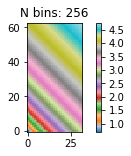

In [17]:
colors1 = getColorList("tab20",20)
print colors1[10:12]
colors1[10] = "#7E975Fff"
colors1[11] = "#D3ECA3ff"

colors = colors1
print len(colors),kernels.shape[0]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)
lib.plotter.testColorMap(cmap)
plt.rc('axes', prop_cycle=(cycler('color', colors)))

In [18]:
kernels["colors"] = colors[:kernels.shape[0]]
kernels.head()

,Name,Total time,order,colors
0,"void cudnn::detail::dgrad_engine<float, int=12...",1.477627,0,#1f77b4ff
1,"void cudnn::detail::wgrad_alg0_engine<float, i...",1.229325,1,#aec7e8ff
2,"void gen_sequenced<curandStateXORWOW, float, i...",0.884266,2,#ff7f0eff
3,"generate_seed_pseudo(unsigned __int64, unsigne...",0.230266,3,#ffbb78ff
4,"void cudnn::detail::wgrad_alg0_engine<float, i...",0.192185,4,#2ca02cff


In [19]:
def addOrderColumn(df,kernels):
    df = pd.merge(df,kernels,on="Name",how="left")
    return df

In [20]:
nvprof_col = addOrderColumn(nvprof,kernels)
nvprof_col.head()

,Type,Time(%),Time,Calls,Avg,Min,Max,Name,batch,conv,Total time,order,colors
0,GPU activities,32.228425,0.009629,1.0,0.009629,0.009629,0.009629,"void cudnn::detail::wgrad_alg0_engine<float, i...",10,128,0.009629,9,#c5b0d5ff
1,GPU activities,29.041489,0.008676,1.0,0.008676,0.008676,0.008676,"void cudnn::detail::dgrad_engine<float, int=12...",10,128,0.093495,6,#d62728ff
2,GPU activities,19.997581,0.005975,1.0,0.005975,0.005975,0.005975,"generate_seed_pseudo(unsigned __int64, unsigne...",10,128,0.230266,3,#ffbb78ff
3,GPU activities,18.428638,0.005506,4.0,0.001376,0.000009,0.002809,"void gen_sequenced<curandStateXORWOW, float, i...",10,128,0.884266,2,#ff7f0eff
4,GPU activities,0.289301,0.000086,1.0,0.000086,0.000086,0.000086,"void scalePackedTensor_kernel<float, float>(cu...",10,128,0.030805,8,#9467bdff


### Make short kernel names

In [21]:
def shortKernels(df):
    df["kernel"] = df["Name"].str.replace("void ","")
    df["kernel"] = df["kernel"].str.replace("cudnn::detail::","")
    df["kernel"] = df["kernel"].str.replace("<"," ")
    df["kernel"] = df["kernel"].str.replace("float","f")
    df["kernel"] = df["kernel"].str.replace("int","i")
    df["kernel"] = df["kernel"].str.replace("bool","b")
    df["kernel"] = df["kernel"].str.replace("=","")
    df["kernel"] = df["kernel"].apply(lambda s: str(s).split(">")[0])
    df[["batch","conv"]] = df[["batch","conv"]].astype(np.int)
    
    df["kernel"] = df["order"].map(str) + " " + df["kernel"]
    return df
nvprof_col = shortKernels(nvprof_col)
nvprof_col.sort_values(by="order",inplace=True,ascending=True)
nvprof_col.head()

,Type,Time(%),Time,Calls,Avg,Min,Max,Name,batch,conv,Total time,order,colors,kernel
267,GPU activities,33.206036,0.050393,1.0,0.050393,0.050393,0.050393,"void cudnn::detail::dgrad_engine<float, int=12...",130,64,1.477627,0,#1f77b4ff,"0 dgrad_engine f, i128, i6, i7, i3, i3, i5, b0"
112,GPU activities,42.370740,0.054064,1.0,0.054064,0.054064,0.054064,"void cudnn::detail::dgrad_engine<float, int=12...",160,32,1.477627,0,#1f77b4ff,"0 dgrad_engine f, i128, i6, i7, i3, i3, i5, b0"
29,GPU activities,29.353951,0.033327,1.0,0.033327,0.033327,0.033327,"void cudnn::detail::dgrad_engine<float, int=12...",50,128,1.477627,0,#1f77b4ff,"0 dgrad_engine f, i128, i6, i7, i3, i3, i5, b0"
133,GPU activities,41.894060,0.059364,1.0,0.059364,0.059364,0.059364,"void cudnn::detail::dgrad_engine<float, int=12...",190,32,1.477627,0,#1f77b4ff,"0 dgrad_engine f, i128, i6, i7, i3, i3, i5, b0"
36,GPU activities,28.245362,0.036992,1.0,0.036992,0.036992,0.036992,"void cudnn::detail::dgrad_engine<float, int=12...",60,128,1.477627,0,#1f77b4ff,"0 dgrad_engine f, i128, i6, i7, i3, i3, i5, b0"


### List colors per kernel

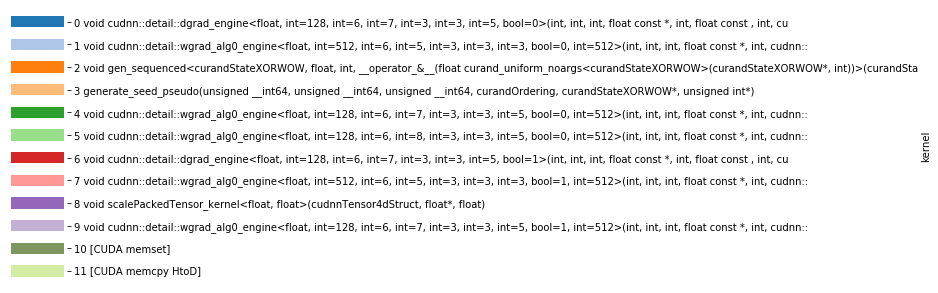

In [22]:
dfc_ = kernels.copy()
dfc_["y"] = 1
fig,ax = plt.subplots(figsize=(1,5))
ax1 = ax.twinx()
for a in [ax,ax1]:
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.spines["left"].set_visible(False)
    a.spines["bottom"].set_visible(False)
    a.get_yaxis().set_visible(False)
    a.get_xaxis().set_visible(False)
dfc_["kernel"] = dfc_["order"].map(str) + " " + dfc_["Name"]
dfc_["kernel"] = dfc_["kernel"].apply(lambda x: x[:150])
dfc_.sort_values(by="order",ascending=False,inplace=True)
dfc_.plot.barh(x="kernel",y="y",color=dfc_["colors"].values,ax=ax1)
ax1.legend().set_visible(False)
plt.show()

## Plot kernel times

In [23]:
def plotAreaTime(data,values="Time",ax=None):
    df = data.copy()
    df.sort_values(by="order",inplace=True,ascending=True)
    # Use order column to make new columns in the right order
    df = df.pivot_table(index="batch",values=values, columns=["order","kernel"])
    df.columns = df.columns.droplevel()
    df.fillna(0, inplace=True)
    if ax is None:
        fig,ax = plt.subplots(figsize=(5,6))
        
    X = np.asarray(sorted(df.index.unique()))
    Y = np.asarray(df.values)
    Y = np.transpose(Y)
    labels = df.columns.values
    colorlist = []
    for kernel in labels:
        color = str(data[data["kernel"]==kernel]["colors"].values[0])
        colorlist.append(color)
#     for i in range(0,len(labels)):
#         labels[i] = labels[i][:50]
    ax.stackplot(X,Y,labels=labels,colors=colorlist)
    batches = df.index.values    
    ax.set_xlim(0,None)
    ax.set_ylim(0,None)
    return ax

/home/peter/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Arial Narrow'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


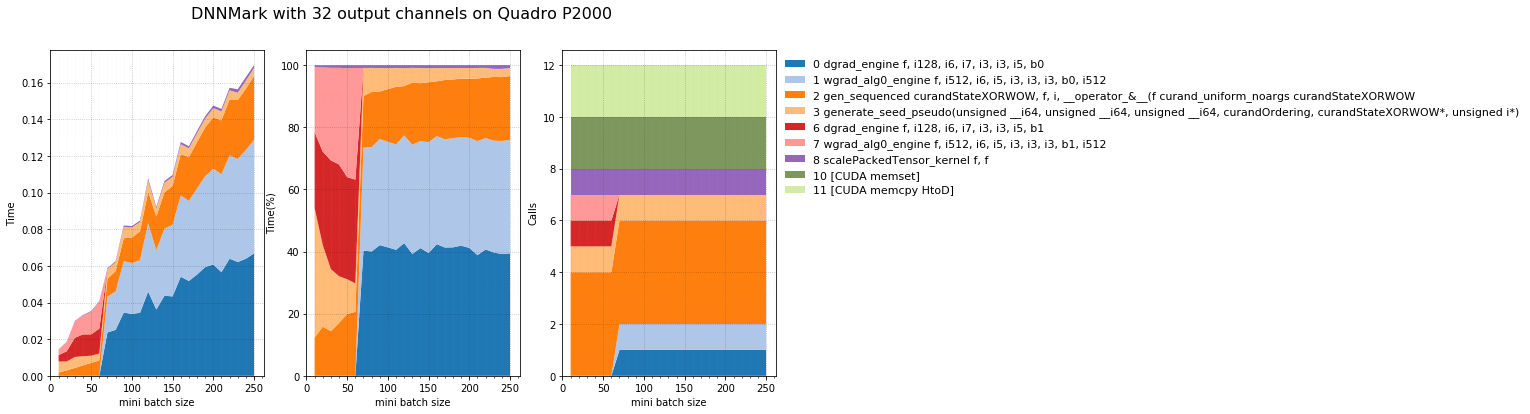

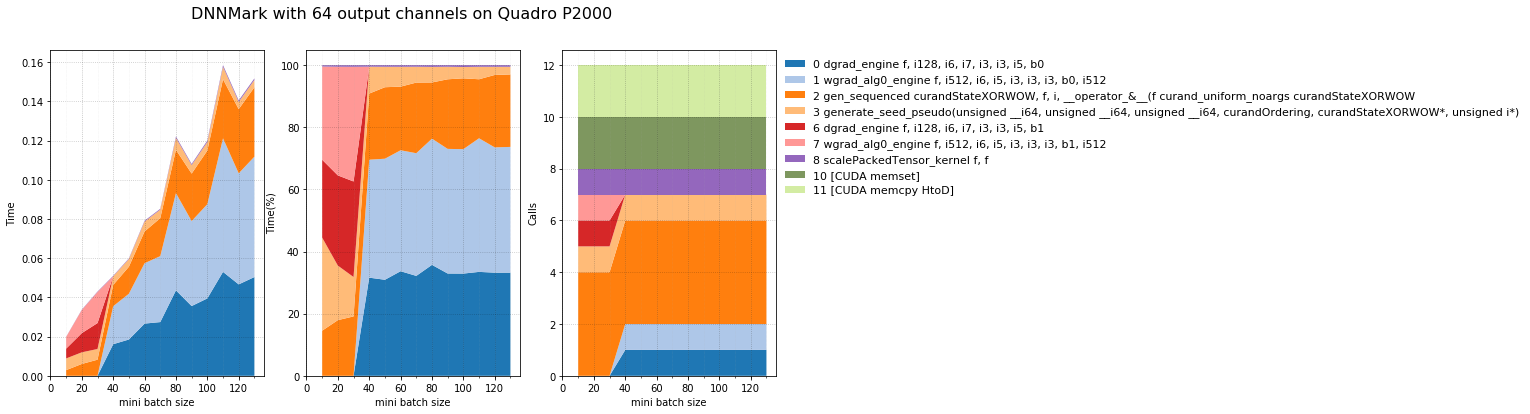

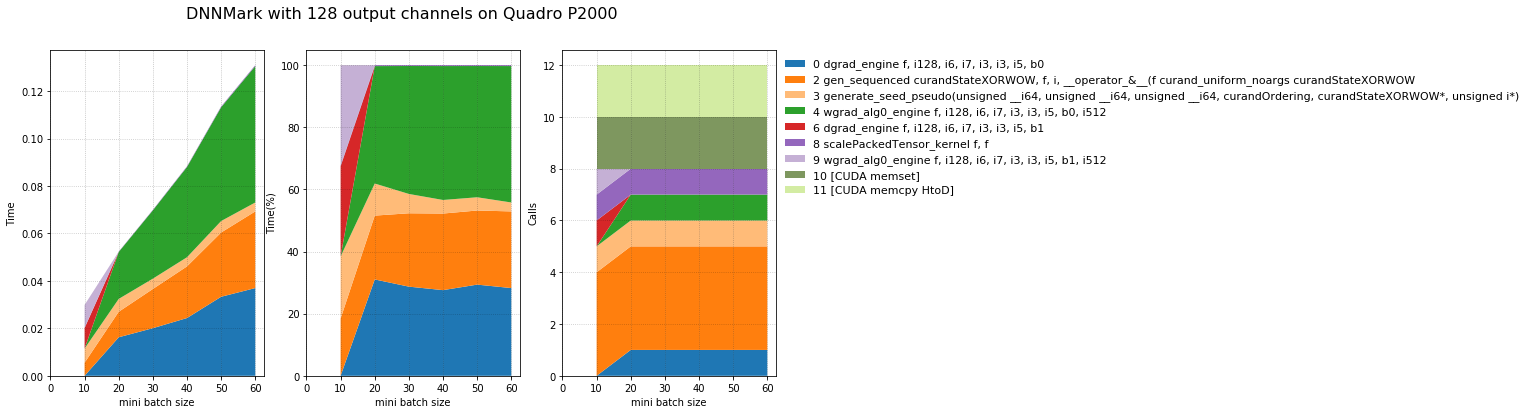

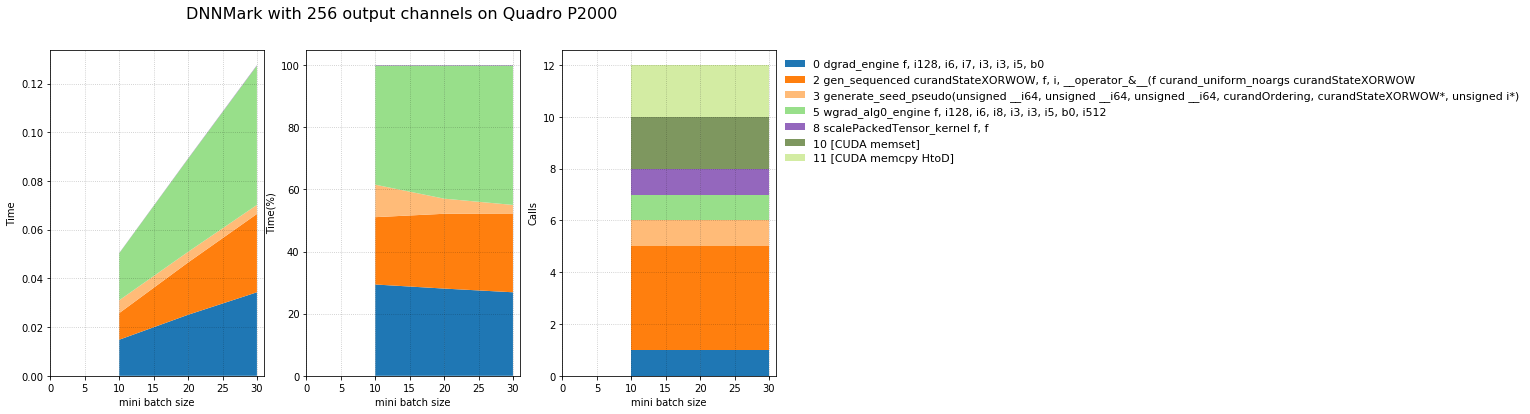

In [24]:
def plotFaceGridTime(df,title=None,values="Time"):
    axes = []
    for conv in sorted(df["conv"].unique()):
        axs = [None]
        if not isinstance(values, list): 
            values = [values]                        
        else:
            if len(values) > 1:
                fig,axs = plt.subplots(1,len(values),figsize=((len(values)-1)*4 + 5,6))
        for i,zz in enumerate(zip(axs,values)):            
            ax = zz[0]
            value = zz[1]
            ax = plotAreaTime(df[df["conv"]==conv],values=value,ax=ax)
            ax.grid(which="major",ls=":",alpha=0.25, color="black")
            minorLocatorX = MultipleLocator(10)
            ax.xaxis.set_minor_locator(minorLocatorX)
            ax.grid(which='minor', linestyle=':', linewidth=.5, alpha=.3)
            ax.set_ylabel(value)
            ax.set_xlabel("mini batch size")
            leg = ax.legend(frameon=False, framealpha=0.4,loc='upper left',bbox_to_anchor=(1, 1))
            if i < len(values)-1:
                ax.legend().set_visible(False)
            axes.append(ax)
         
        plt.setp(ax.get_legend().get_texts(), fontsize='11')
        plt.setp(ax.get_legend().get_texts(), family='Arial Narrow')
        plt.suptitle("DNNMark with {} output channels on {}".format(conv,title),fontsize=16)
        plt.show()
    return axes
        
plotFaceGridTime(nvprof_col,title="Quadro P2000",values=["Time","Time(%)","Calls"])
plt.show()

### Kernels distribution

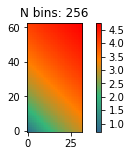

In [25]:
colors1 = getColorList("viridis",4)
colors2 = getColorList("autumn_r",3)
colors = colors1[1:-1] + colors2[1:]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)
lib.plotter.testColorMap(cmap)
plt.rc('axes', prop_cycle=(cycler('color', colors)))

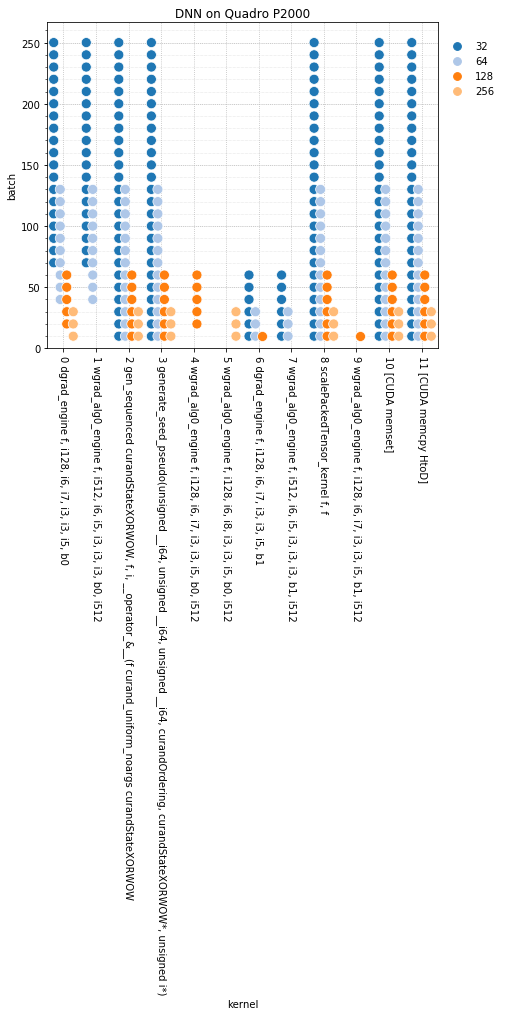

In [43]:
# CAUTION! Takes very long time to plot

def plotKernelsDistr(df,title):
    fig,ax = plt.subplots(figsize=(7,6))
    cp = sns.color_palette(df["colors"].unique())
    sns.swarmplot(x="kernel",y="batch",hue="conv",palette=cp,edgecolor="white",linewidth=.7, data=df, dodge=True,s=10,ax=ax)
    minorLocator = MultipleLocator(10)
    ax.yaxis.set_minor_locator(minorLocator)
    ax.grid(ls=":",alpha=.9)
    ax.grid(which='minor', linestyle=':', linewidth=.5, alpha=.7)
    ax.set_ylim(0,None)
    plt.xticks(rotation=270)
    plt.title(title)
    #plt.legend().set_visible(False)
    ax.legend(bbox_to_anchor=(1, 0.97), loc='upper left',edgecolor="white")
    #ax.legend(frameon=False, framealpha=0.4,ncol=2,loc='upper left',bbox_to_anchor=(1, 1))
    plt.show()

plotKernelsDistr(nvprof_col,"DNN on Quadro P2000")
